**Copyright 2020 Marcel Arpogaus**

    Licensed under the Apache License, Version 2.0 (the "License");
    you may not use this file except in compliance with the License.
    You may obtain a copy of the License at
 
        http://www.apache.org/licenses/LICENSE-2.0
 
    Unless required by applicable law or agreed to in writing, software
    distributed under the License is distributed on an "AS IS" BASIS,
    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    See the License for the specific language governing permissions and
    limitations under the License.

**Note:** You might want to install the [`jupyter_latex_envs`](https://github.com/jfbercher/jupyter_latex_envs/) extension for Jupyter notebook to display the citations correctly.

# Implementation of Bernstein-Polynomials as TensorFlow Probability Bijector

Normalizing flows (NF) \cite{tabak-FamilyNonparametricDensity-2013} are a type of transformation model that can be used for density estimation.
Instead of parameterizing a density function to fit the shape of the desired conditional probability distribution, they use a single simple PDF, usually a Gaussian. As a *base distribution* and pass it through a series of special transformation functions until it is most similar to the *data distribution*.
This composition of simple transformation functions allows NF based models to be very expressive, while staying computational efficient \cite{papamakarios-NormalizingFlowsProbabilistic-2019}.

Conditioned normalizing flows can be used for complex conditional density estimation (CDE), without assuming much about their shape \cite{hothorn-MostLikelyTransformations-2018, sick-DeepTransformationModels-2020}.
Their expressiveness is highly dependent on the flexibility of the used transformation functions.
A recent study \cite{sick-DeepTransformationModels-2020} presented a new type of flow-based transformation models especially optimized for CDE.
They joined ideas from statistical transformation models \cite{hothorn-MostLikelyTransformations-2018} as well as deep normalizing flows \cite{tabak-FamilyNonparametricDensity-2013} and were able to outperform existing models for complex distributions far away from Gaussian.

Compared to the statistical transformation models the proposed deep transformation model does not require predefined features and can be trained in an end-to-end fashion from complex data.
The very expressive Bernstein polynomials are used as basis transformations \cite{hothorn-MostLikelyTransformations-2018} combined in a composition of four different transformation functions to build a NF.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/blob/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/blob/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/MArpogaus/TensorFlow-Probability-Bernstein-Polynomial-Bijector/master/Bernstein_Bijector.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies-&amp;-Prerequisites" data-toc-modified-id="Dependencies-&amp;-Prerequisites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dependencies &amp; Prerequisites</a></span><ul class="toc-item"><li><span><a href="#Import-Libaries" data-toc-modified-id="Import-Libaries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libaries</a></span></li><li><span><a href="#Ensure-Reproducibility" data-toc-modified-id="Ensure-Reproducibility-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Ensure Reproducibility</a></span></li><li><span><a href="#File-Paths" data-toc-modified-id="File-Paths-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File Paths</a></span></li></ul></li><li><span><a href="#Function-Definitions" data-toc-modified-id="Function-Definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function Definitions</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#TensorFlow-Dataset-API" data-toc-modified-id="TensorFlow-Dataset-API-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>TensorFlow Dataset API</a></span></li></ul></li><li><span><a href="#Bernstein-Bijector-as-Distribution-Lambda" data-toc-modified-id="Bernstein-Bijector-as-Distribution-Lambda-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bernstein Bijector as Distribution Lambda</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li><li><span><a href="#Berstein-Bijector-as-Loss" data-toc-modified-id="Berstein-Bijector-as-Loss-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Berstein Bijector as Loss</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Testing</a></span></li></ul></li></ul></div>

##  Dependencies & Prerequisites

### Import Libaries

In [1]:
import os
import pandas as pd
import numpy as np

from functools import partial

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="paper")  # improved plt styles

In [39]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

Import The Bernstein Bijector flow and loss classes.

In [4]:
from bernstein_flow.bijectors import BernsteinBijector
from bernstein_flow.distributions import BernsteinFlow
from bernstein_flow.losses import BernsteinFlowLoss

In [5]:
from bernstein_flow.util.visualization import vizualize_flow_from_z_domain
from bernstein_flow.util.visualization import plot_chained_bijectors
from bernstein_flow.util.visualization import plot_flow

### Ensure Reproducibility

In [6]:
np.random.seed(2)
tf.random.set_seed(2)
print("TFP Version", tfp.__version__)
print("TF  Version", tf.__version__)

TFP Version 0.11.0
TF  Version 2.3.0


### File Paths

In [7]:
gfx_path = './gfx'

## Function Definitions

We want to directly minimize the negative log-likelihood:

In [8]:
def negloglik(y_true, y_hat):
    nll = -y_hat.log_prob(y_true)
    return nll

## Data

Classic dataset containing the waiting time between eruptions and the duration of the eruption for the [Old Faithful Geyser](https://en.wikipedia.org/wiki/Old_Faithful) in [Yellowstone National Park](https://en.wikipedia.org/wiki/Yellowstone_National_Park).

Extracted from the [built-in dataset in R](https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/faithful.html).

Reference: \cite{azzalini-LookDataOld-1990}

In [9]:
y = np.asarray(
    (0.6694, 0.3583, 0.6667, 0.6667, 0.6667, 0.3333, 0.7306, 0.7139, 0.3389, 0.8056, 0.3056, 0.9083, 0.2694, 0.8111,
     0.7306, 0.2944, 0.7778, 0.3333, 0.7889, 0.7028, 0.3167, 0.8278, 0.3333, 0.6667, 0.3333, 0.6667, 0.4722, 0.75,
     0.6778, 0.6194, 0.5861, 0.7444, 0.3694, 0.8139, 0.4333, 0.6917, 0.3667, 0.7944, 0.3056, 0.7667, 0.3778, 0.6889,
     0.3333, 0.6667, 0.3333, 0.6667, 0.3139, 0.7111, 0.3472, 0.7444, 0.4167, 0.6667, 0.2944, 0.7222, 0.3639, 0.7472,
     0.6472, 0.5556, 0.6222, 0.6667, 0.325, 0.8778, 0.3333, 0.6667, 0.3333, 0.6667, 0.3333, 0.6667, 0.5889, 0.3611, 0.75,
     0.3361, 0.6917, 0.7, 0.7222, 0.3222, 0.775, 0.6361, 0.6722, 0.6944, 0.7778, 0.3028, 0.6667, 0.5, 0.6667, 0.3333, 0.7417,
     0.3417, 0.7083, 0.3194, 0.7778, 0.2889, 0.7306, 0.2944, 0.7667, 0.3111, 0.7417, 0.2722, 0.8389, 0.3028, 0.85, 0.2722, 0.7139,
     0.3333, 0.6667, 0.3333, 0.7556, 0.3333, 0.6667, 0.4889, 0.7889, 0.65, 0.325, 0.6861, 0.3, 0.7778, 0.3056, 0.7833, 0.3528, 0.7972,
     0.3028, 0.6833, 0.775, 0.6667, 0.3333, 0.6667, 0.6667, 0.7028, 0.6889, 0.6556, 0.625, 0.7361, 0.4111, 0.6944, 0.6333, 0.7194,
     0.6444, 0.7806, 0.2833, 0.8278, 0.7111, 0.7639, 0.6667, 0.6667, 0.6667, 0.6667, 0.3306, 0.7667, 0.1389, 0.8194, 0.2889, 0.7639,
     0.2833, 0.7917, 0.3056, 0.75, 0.3111, 0.7417, 0.7417, 0.6667, 0.8, 0.6667, 0.6667, 0.3333, 0.6667, 0.3222, 0.7639, 0.3333, 0.6167,
     0.4778, 0.8056, 0.575, 0.7306, 0.3, 0.7333, 0.4139, 0.7528, 0.35, 0.725, 0.7278, 0.2972, 0.8194, 0.3028, 0.6667, 0.6667, 0.6667, 0.6444,
     0.3083, 0.7833, 0.3361, 0.7444, 0.3111, 0.6944, 0.3167, 0.7083, 0.5417, 0.7028, 0.3139, 0.8306, 0.3083, 0.6667, 0.3278, 0.7944, 0.6667, 0.3333,
     0.6667, 0.6667, 0.3972, 0.7361, 0.7028, 0.7278, 0.3333, 0.7417, 0.2917, 0.75, 0.2694, 0.7833, 0.4278, 0.6167, 0.7056, 0.3222, 0.725, 0.6667, 0.6667,
     0.6667, 0.7028, 0.6667, 0.6889, 0.3139, 0.7444, 0.325, 0.7028, 0.2861, 0.7417, 0.7083, 0.6611, 0.7306, 0.3278, 0.7417, 0.7111, 0.3194, 0.7361, 0.5,
     0.6667, 0.3333, 0.6667, 0.5472, 0.3056, 0.7694, 0.3056, 0.7694, 0.7667, 0.7083, 0.3222, 0.8306, 0.3278, 0.7167, 0.7, 0.7556, 0.7333, 0.7694, 0.3333,
     0.6667, 0.6667, 0.6528, 0.3333, 0.75, 0.3, 0.6667, 0.4583, 0.7889, 0.6611, 0.325, 0.8278, 0.3083, 0.8, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
     0.6667, 0.3333, 0.6667, 0.3222, 0.7222, 0.2778, 0.7944, 0.325, 0.7806, 0.3222, 0.7361, 0.3556, 0.6806, 0.3444, 0.6667, 0.6667, 0.3333),
    np.float32
)

In [10]:
x = np.ones((y.shape[0], 1))

### TensorFlow Dataset API

[`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) API supports writing descriptive and efficient input pipelines

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=len(y))
dataset = dataset.batch(32)
dataset = dataset.prefetch(1)
dataset

<PrefetchDataset shapes: ((None, 1), (None,)), types: (tf.float64, tf.float32)>

In [12]:
x_sample, y_sample = next(dataset.as_numpy_iterator())
x_sample.shape, y_sample.shape

((32, 1), (32,))

## Bernstein Bijector as Distribution Lambda

In [13]:
# basis distribution
base_dist = tfd.Normal(0, 1)  # The distribution of z

### Model Definition

In [35]:
neurons = 32  # Neurons of the DNN hidden layers
M = 9         # Order of Bernstin polynomial

OutputLayer = partial(
    tf.keras.layers.Dense,
    activation="linear",
    use_bias=False,
    # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)

inputs = tf.keras.layers.Input(shape=(1,))

pvector = OutputLayer(
    4+M,
    name="pvector"
)(inputs)

pvector_rshpd = Reshape((1, -1))(pvector)

def bernstein_lambda(pvector):
    return BernsteinFlow(
        M
    )(pvector)

output = tfp.layers.DistributionLambda(bernstein_lambda)(
    pvector_rshpd
)

flow_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[output],
    name='flow')
flow_model.summary()

Model: "flow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pvector (Dense)              (None, 13)                13        
_________________________________________________________________
reshape_3 (Reshape)          (None, 1, 13)             0         
_________________________________________________________________
distribution_lambda_2 (Distr ((1,), (1,))              0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [36]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=negloglik
)

### Training

In [37]:
flow_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=negloglik
)
hist = flow_model.fit(
    dataset,
    epochs=3000,
    verbose=False
)

(<AxesSubplot:>, -0.49257326126098633)

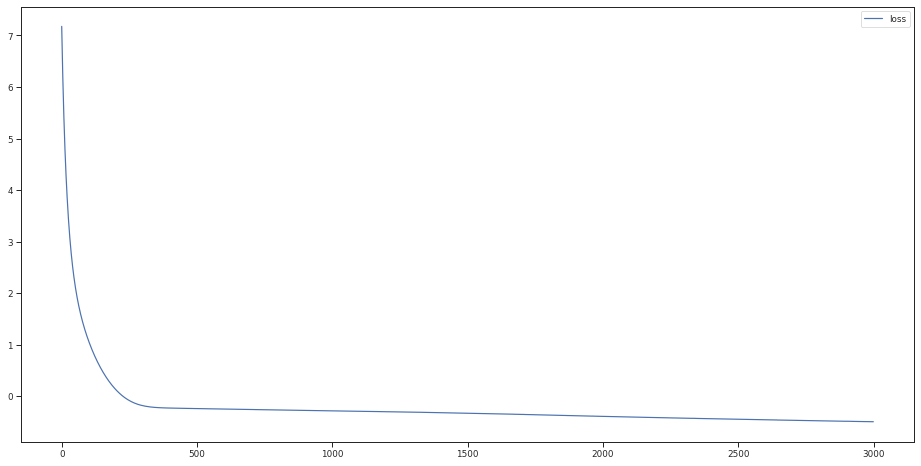

In [40]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(figsize=(16,8)), hist_df.loss.min()

### Testing

In [18]:
x_test = np.ones((1, 1), dtype='float32')

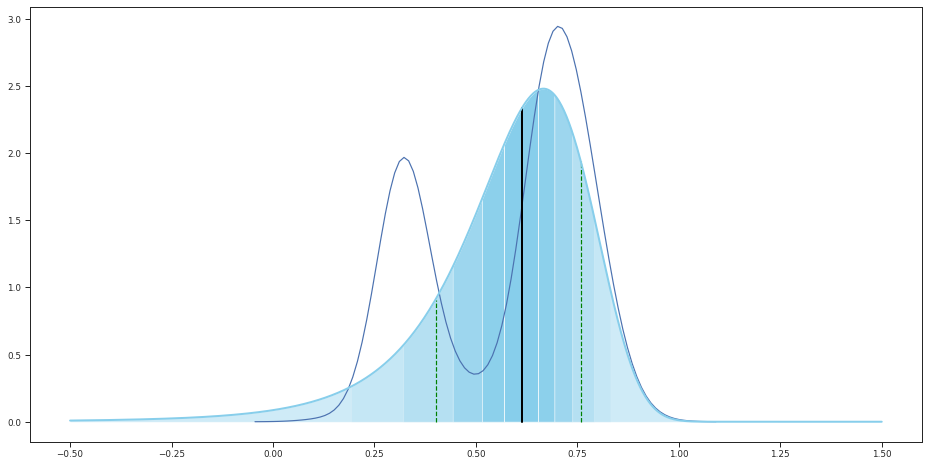

In [19]:
flow = flow_model(x_test).distributions.model[0]
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

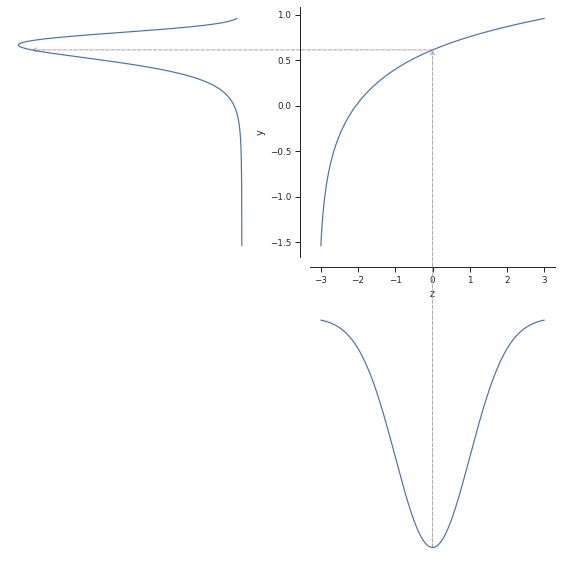

In [20]:
fig=vizualize_flow_from_z_domain(flow)

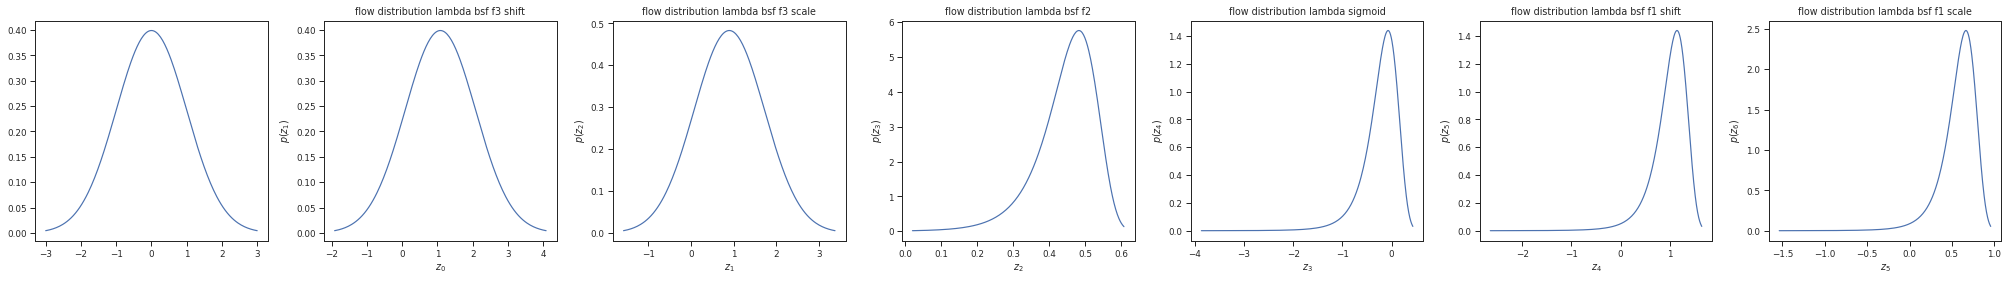

In [21]:
plot_chained_bijectors(flow)

In [22]:
b2 = flow.bijector.bijector.bijectors[0].shift
a2 = flow.bijector.bijector.bijectors[1].scale
theta = flow.bijector.bijector.bijectors[2].theta
b1 = flow.bijector.bijector.bijectors[4].shift
a1 = flow.bijector.bijector.bijectors[5].scale

In [23]:
print(f"""
a1 = {repr(a1.numpy())}
b1 = {repr(b1.numpy())}
theta = {repr(theta.numpy())}
a2 = {repr(a2.numpy())}
b2 = {repr(b2.numpy())}
""")


a1 = array([[1.7226064]], dtype=float32)
b1 = array([[-1.2180794]], dtype=float32)
theta = array([[-1.6404109 , -1.3047563 , -0.85913074, -0.19232637,  0.7124824 ,
         1.779032  ,  4.180665  , 12.987617  , 34.699047  ]],
      dtype=float32)
a2 = array([[1.2105191]], dtype=float32)
b2 = array([[-1.0823802]], dtype=float32)



## Berstein Bijector as Loss

The Bernstein bijector can also be used as a Keras loss function.

### Model Definition

In [24]:
neurons = 32  # Neurons of the DNN hidden layers
M = 9         # Order of Bernstin polynomial


OutputLayer = partial(
    tf.keras.layers.Dense,
    activation="linear",
    use_bias=False,
    # kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)

inputs = tf.keras.layers.Input(shape=(1,))

pvector = OutputLayer(
    4+M,
    name="pvector"
)(inputs)

out = Reshape((1, -1))(pvector)

flow_parameter_model = tf.keras.Model(
    inputs=[inputs],
    outputs=[out],
    name='bs_loss')
flow_parameter_model.summary()

Model: "bs_loss"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
pvector (Dense)              (None, 13)                13        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 13)             0         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [25]:
flow_parameter_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss=BernsteinFlowLoss(M)
)

### Training

In [26]:
# Do inference.
hist = flow_parameter_model.fit(
    dataset,
    epochs=3000,
    verbose=False
)

(<AxesSubplot:>, -0.49257326126098633)

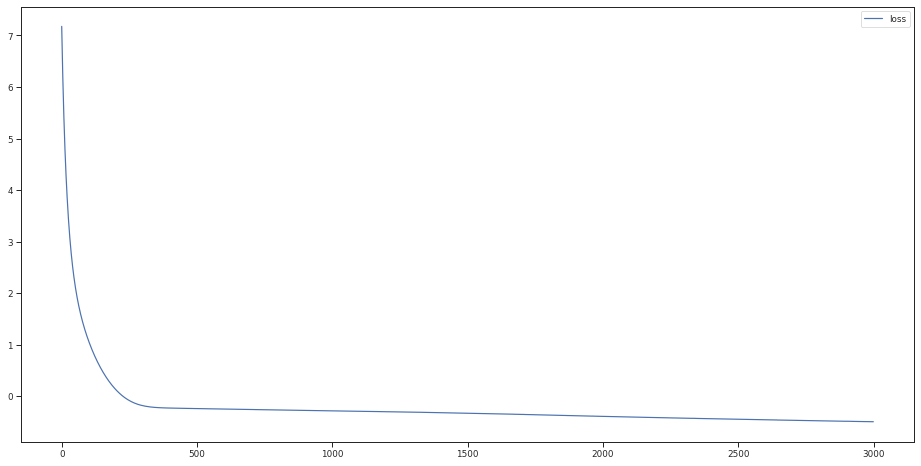

In [41]:
hist_df = pd.DataFrame(hist.history)
hist_df.plot(figsize=(16,8)), hist_df.loss.min()

### Testing

In [28]:
x_test = np.ones((1, 1), dtype='float32')

In [29]:
pvs = flow_parameter_model(x_test)
flow = BernsteinFlow(M)(pvs).distributions.model[0]

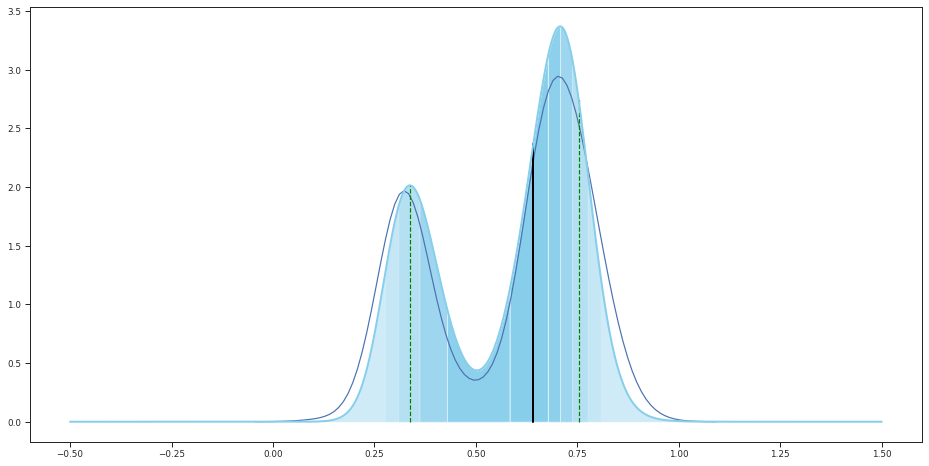

In [30]:
yy = np.linspace(-0.5, 1.5, 1000, dtype=np.float32)
plt.figure(figsize=(16, 8))
sns.kdeplot(y)
plot_flow(flow, yy[..., None])

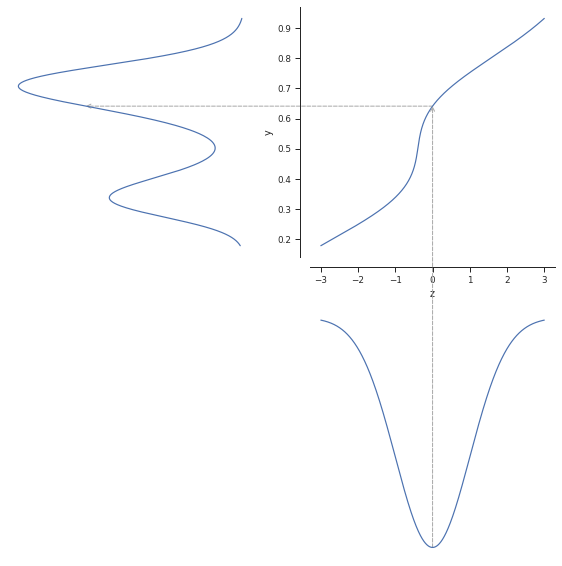

In [31]:
fig=vizualize_flow_from_z_domain(flow)

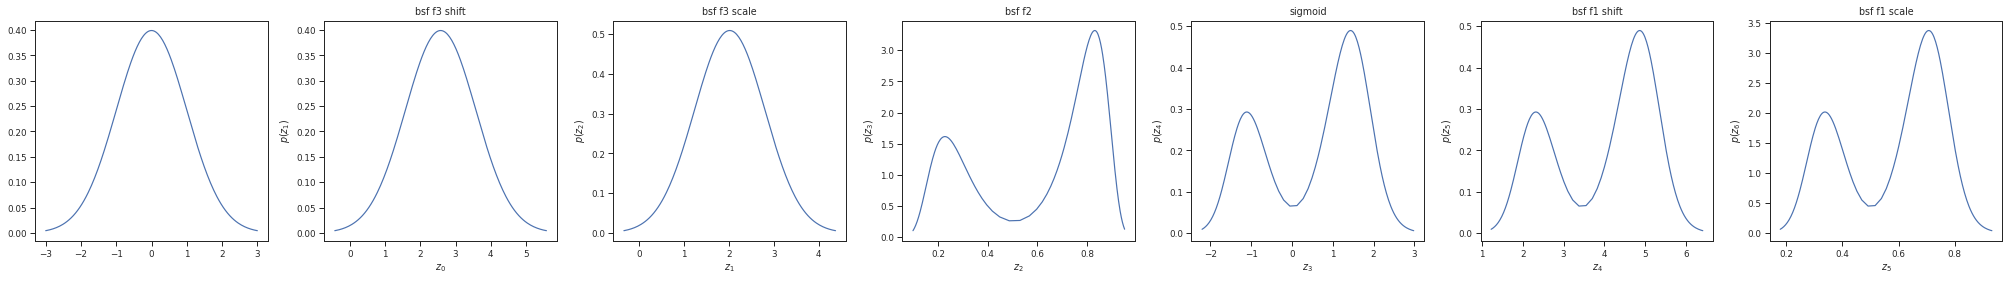

In [32]:
plot_chained_bijectors(flow)

# References

[<a id="cit-tabak-FamilyNonparametricDensity-2013" href="#call-tabak-FamilyNonparametricDensity-2013">1</a>] Tabak E. G. and Turner Cristina V., ``_A Family of Nonparametric Density Estimation Algorithms_'', , vol. 66, number 2, pp. 145--164,  2013.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpa.21423)

[<a id="cit-papamakarios-NormalizingFlowsProbabilistic-2019" href="#call-papamakarios-NormalizingFlowsProbabilistic-2019">2</a>] Papamakarios George, Nalisnick Eric, Rezende Danilo Jimenez <em>et al.</em>, ``_Normalizing Flows for Probabilistic Modeling and Inference_'', , vol. , number , pp. ,  2019.  [online](http://arxiv.org/abs/1912.02762)

[<a id="cit-hothorn-MostLikelyTransformations-2018" href="#call-hothorn-MostLikelyTransformations-2018">3</a>] Hothorn Torsten, Möst Lisa and Bühlmann Peter, ``_Most Likely Transformations_'', , vol. 45, number 1, pp. 110--134,  2018.  [online](https://onlinelibrary.wiley.com/doi/abs/10.1111/sjos.12291)

[<a id="cit-sick-DeepTransformationModels-2020" href="#call-sick-DeepTransformationModels-2020">4</a>] Sick Beate, Hothorn Torsten and Dürr Oliver, ``_Deep transformation models: Tackling complex regression problems with neural network based transformation models_'', , vol. , number , pp. ,  2020.  [online](http://arxiv.org/abs/2004.00464)

[<a id="cit-azzalini-LookDataOld-1990" href="#call-azzalini-LookDataOld-1990">5</a>] Azzalini A. and Bowman A. W., ``_A Look at Some Data on the Old Faithful Geyser_'', , vol. 39, number 3, pp. 357--365,  1990.

